In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller

import warnings
import pickle
from pyxirr import xirr
warnings.filterwarnings('ignore')

# 1. Find Cointegrated Pairs of Stocks

In [5]:
df = pd.read_pickle('Full_Master_FNO_Stocks.pkl')
df.index = df['date']
df = df.drop(['date'], axis=1)
#Downsampling to 15 mins timeframe to 1 min timeframe to save computation time
df1 = df[::15]

In [5]:
#Using coint function from statsmodels
#Considering pairs with p-value less than 0.01 -> Less than 1% chance that they only seem cointegrated and aren't actually cointegrated

def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        print(f"{i+1}/{n}")
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.01:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [6]:
pvalue_matrix, pairs = find_cointegrated_pairs(df1)

In [150]:
#Save the pairs into a pickle file
with open('new_coint_pairs.pkl', 'wb') as file:
    pickle.dump(pairs, file)

# 2. Filter & Validate Cointegrated Pairs of stocks

In [5]:
#Load the list of pairs
with open('new_coint_pairs.pkl', 'rb') as file:
    exhaustive_pairs = pickle.load(file)

In [2]:
#Manually select pairs based business understanding
logical_pairs = [
    ('ABBOTINDIA', 'BIOCON'),
    ('ADANIPORTS', 'CONCOR'),
    ('HDFCAMC', 'ICICIGI'),
    ('OBEROIRLTY', 'GMRINFRA'),
    ('EICHERMOT', 'MARUTI'),
    ('PIIND', 'BHARATFORG'),
    ('PIIND', 'TORNTPHARM'),
    ('PIDILITIND', 'NAVINFLUOR'),
    ('PIDILITIND', 'INDIACEM'),
    ('DABUR', 'GODREJCP'),
    ('DABUR', 'DALBHARAT'),
    ('ASTRAL', 'DEEPAKNTR'),
    ('M&MFIN', 'M&M'),
    ('SBILIFE', 'CIPLA'),
    ('SBILIFE', 'BIOCON'),
    ('SBILIFE', 'TORNTPHARM'),
    ('SIEMENS', 'ABB'),
    ('SIEMENS', 'CUMMINSIND'),
    ('BAJAJFINSV', 'APOLLOHOSP'),
    ('MUTHOOTFIN', 'IBULHSGFIN'),
    ('MUTHOOTFIN', 'OFSS'),
    ('CONCOR', 'ACC'),
    ('HDFCBANK', 'AXISBANK'),
    ('CHOLAFIN', 'AUBANK'),
    ('GUJGASLTD', 'RAIN'),
    ('ITC', 'BIOCON'),
    ('ITC', 'COALINDIA'),
    ('CIPLA', 'BIOCON'),
    ('TATACOMM', 'HONAUT'),
    ('ONGC', 'NATIONALUM'),
    ('CHAMBLFERT', 'NATIONALUM'),
    ('ABB', 'BEL'),
    ('PETRONET', 'DEEPAKNTR'),
    ('PETRONET', 'COALINDIA'),
    ('PETRONET', 'HAL'),
    ('ICICIGI', 'IBULHSGFIN'),
    ('COALINDIA', 'HAL'),
    ('PETRONET', 'JSWSTEEL'),
    ('PETRONET', 'GNFC'),
    ('TRENT', 'ABFRL'),
    ('DRREDDY', 'ZYDUSLIFE'),
    ('ONGC', 'NATIONALUM'),
    ('GLENMARK', 'ICICIGI'),
    ('DALBHARAT', 'JKCEMENT'),
    ('BIOCON', 'SUNPHARMA')
]

In [6]:
#validated_logical_pairs - stores validated pairs filtered logically from cointegrated pairs
validated_logical_pairs = []
returns_pairs = []
for assets in logical_pairs:
    asset1 = assets[0]
    asset2 = assets[1]
    
    model=sm.OLS(df1[asset2], df1[asset1]).fit()
    hedge_ratio = model.params[0]

    spread = df1[asset2] - hedge_ratio * df1[asset1]
    adf = adfuller(spread, maxlag = 1)
    
    if adf[0] < -3.43:
        #print(f'ADF critical value for {asset2} and {asset1} is {adf[0]}')
        validated_logical_pairs.append(assets)

print(f'There are {len(validated_logical_pairs)} pairs in validated_logical_pairs')

There are 20 pairs in validated_logical_pairs


In [8]:
#Save the validated_logical_pairs into a pickle file
with open('validated_logical_pairs.pkl', 'wb') as file:
    pickle.dump(validated_logical_pairs, file)

# 3. Let's Model the Spread on an Example

In [ ]:
assets = ('TRENT', 'ABFRL')
asset1,asset2 = assets[0], assets[1]

train = df[[asset1, asset2]]

ax = train[[asset1,asset2]].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

Hedge Ratio =  0.2319036903830773


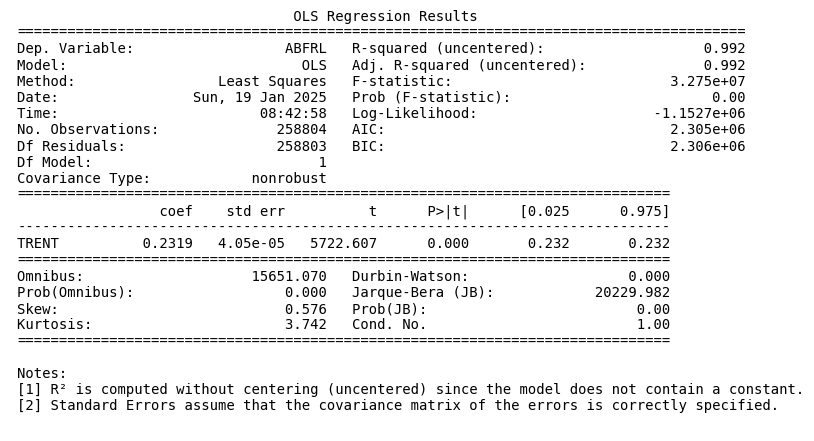

In [11]:
# run OLS regression
model=sm.OLS(train[asset2], train[asset1]).fit()

# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

hedge_ratio = model.params[0]
print('Hedge Ratio = ', hedge_ratio)

Critical Value =  -0.4604036048245976
{'1%': -3.43072910232179, '5%': -2.861707548432376, '10%': -2.5668591817077266}


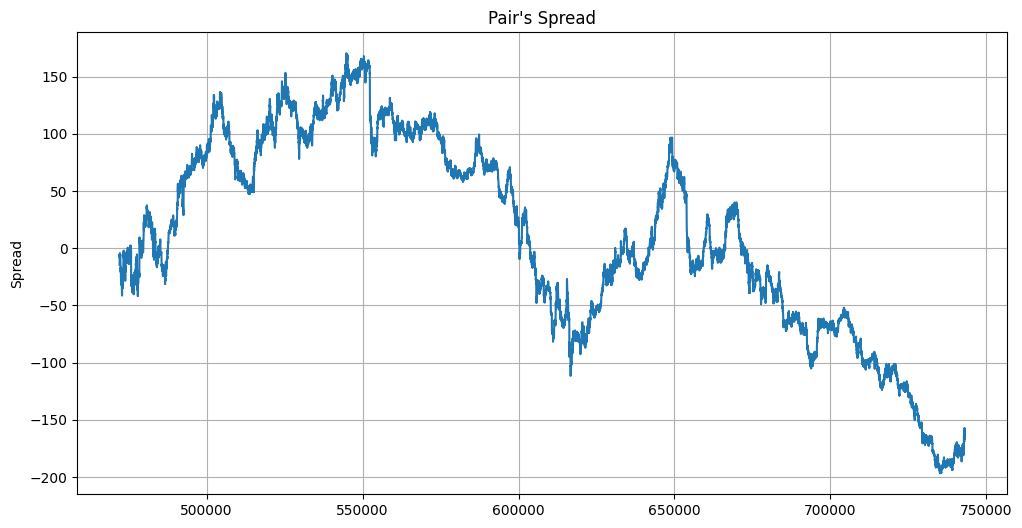

In [114]:
#Calculate spread
spread = 1*train.asset2 - hedge_ratio * train.asset1

# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True)

# conduct Augmented Dickey-Fuller test to check whether the spread is I(0)/ Stationary
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])
# probablity critical values
print(adf[4])

# 4. Backtest Trading Strategy on the Example

In [166]:
assets = ['TRENT', 'ABFRL']
asset1, asset2 = assets[0], assets[1]

window = 30000

backtest_df = df.filter(assets)
backtest_df.index = pd.to_datetime(backtest_df.index).tz_convert(None)

model = RollingOLS(backtest_df[asset1], backtest_df[asset2], window=window).fit()
beta_array = model.params['ABFRL'].dropna().values[1:]

backtest_df1 = backtest_df[window:]
backtest_df1['spread'] = backtest_df1[asset1] - beta_array * backtest_df1[asset2]

mean = backtest_df1['spread'].rolling(window).mean()
std_dev = backtest_df1['spread'].rolling(window).std()

mean_array = mean.dropna().values[1:]
std_array = std_dev.dropna().values[1:]

# 1 window used for OLS, 1 window used for mean & std post OLS
backtest_df1 = backtest_df1[window:]
backtest_df1['z_score'] = (backtest_df1['spread'] - mean_array)/std_array
backtest_df1['beta'] = beta_array[window:]

In [167]:
#Determine Optimal threshold from probability distribution function derived from Training data
train = backtest_df[:window]

train_model = sm.OLS(train[asset2], train[asset1]).fit()
hedge_ratio = train_model.params[0]

train['spread'] = train[asset2] - hedge_ratio * train[asset1]
train['z_score'] = (train['spread'] - train['spread'].mean())/train['spread'].std()

train['s0'] = train['z_score'].abs()
train['cdf'] = 1 - train['s0'].rank(method = 'average', pct = True)
train['cdf*s0'] = train['cdf']*train['s0']

#Find an s0 where CDF*s0 is maximum
threshold = train[train['cdf*s0']==train['cdf*s0'].max()]['s0'].values[0]
threshold = round(threshold, 2)

In [168]:
#Define signals
backtest_df1['buy_zone'] = backtest_df1['z_score'].map(lambda x: 1 if x<-threshold else 0)
backtest_df1['buy_signal'] = backtest_df1['buy_zone'].diff().map(lambda x: max(x,0))

backtest_df1['sell_zone'] = backtest_df1['z_score'].map(lambda x: 1 if x>threshold else 0)
backtest_df1['sell_signal'] = backtest_df1['sell_zone'].diff().map(lambda x: max(x,0))

backtest_df1['exit_signal'] = backtest_df1['z_score']*backtest_df1['z_score'].shift(1)
backtest_df1['exit_signal'] = backtest_df1['exit_signal'].map(np.sign)

In [196]:
# Rs. 800/trade (Buy & Sell for both stocks)
#Introduced slippage 0.3% for both buy & sell, both stocks
orderbook = []
tradebook = []
buy_flag = 0
asset1_lev = 4.56
asset2_lev = 3.00
asset1_qty = 1000
charges = 800
slippage = 0.003 #0.3%

for date in backtest_df1.index:
    if buy_flag == 0 and backtest_df1.loc[date, 'buy_signal'] == 1:
        buy_flag = 1
        asset1_buy = backtest_df1.loc[date, asset1]
        asset2_sell = backtest_df1.loc[date, asset2] 
        margin = asset1_qty*(asset1_buy)/asset1_lev + asset1_qty*backtest_df1.loc[date,'beta']* (asset2_sell)/asset2_lev
        margin = round(margin,0)
        
        orderbook.append([date, asset1_buy, 0, 0, asset2_sell, -margin])
        
    elif buy_flag == 1 and backtest_df1.loc[date, 'exit_signal'] == -1:
        buy_flag = 0 # exit the position
        asset1_sell = backtest_df1.loc[date, asset1]
        asset2_buy = backtest_df1.loc[date, asset2]
        asset2_qty = round(asset1_qty*backtest_df1.loc[date,'beta'],0)
        profit =  asset1_qty*((1-slippage)*asset1_sell - (1+slippage)*asset1_buy) + asset2_qty * ((1-slippage)*asset2_sell - (1+slippage)*asset2_buy)
        profit = round(profit,0) - charges
        
        orderbook.append([date, 0, asset1_sell, asset2_buy, 0, margin+profit])
        tradebook.append([date, asset1_qty, (1+slippage)*asset1_buy, (1-slippage)*asset1_sell, asset2_qty, (1+slippage)*asset2_buy, (1-slippage)*asset2_sell, profit])
        
    elif buy_flag == 0 and backtest_df1.loc[date, 'sell_signal'] == 1:
        buy_flag = -1
        asset1_sell = backtest_df1.loc[date, asset1]
        asset2_buy = backtest_df1.loc[date, asset2]
        margin = asset1_qty*(asset1_sell)/asset1_lev + asset1_qty*backtest_df1.loc[date,'beta']*(asset2_buy)/asset2_lev
        margin = round(margin,0)
        
        orderbook.append([date, 0, asset1_sell, asset2_buy, 0, -margin])
        
    elif buy_flag == -1 and backtest_df1.loc[date, 'exit_signal'] == -1:
        buy_flag = 0 # exit the position
        asset1_buy = backtest_df1.loc[date, asset1]
        asset2_sell = backtest_df1.loc[date, asset2]
        asset2_qty = round(asset1_qty*backtest_df1.loc[date,'beta'],0)
        profit = asset1_qty*((1-slippage)*asset1_sell - (1+slippage)*asset1_buy) + asset2_qty * ((1-slippage)*asset2_sell - (1+slippage)*asset2_buy)
        profit = round(profit,0) - charges
        
        orderbook.append([date, asset1_buy, 0, 0, asset2_sell, margin+profit])
        tradebook.append([date, asset1_qty, (1+slippage)*asset1_buy, (1-slippage)*asset1_sell, asset2_qty, (1+slippage)*asset2_buy, (1-slippage)*asset2_sell, profit])

orderbook_df = pd.DataFrame(orderbook, columns = ['date', asset1+'_buy_price', asset1+'_sell_price', asset2+'_buy_price', asset2+'_sell_price', 'cashflow'])
tradebook_df = pd.DataFrame(tradebook, columns = ['date', asset1+'_qty', asset1+'_buy_price', asset1+'_sell_price', asset2+'_qty', asset2+'_buy_price', asset2+'_sell_price', 'profit'])


In [204]:
print(f'Total profit is {tradebook_df['profit'].sum()}')
print(f'XIRR of the strategy is {xirr(orderbook_df[:-1]['date'], orderbook_df[:-1]['cashflow'])}')

Total profit is 861913.0
XIRR of the strategy is 3.531962060900937


In [219]:
total_profit = tradebook_df['profit'].sum()
margin = abs(orderbook_df[orderbook_df['cashflow']<0]['cashflow'].min())
CAGR = 100*((total_profit/margin + 1)**0.5 - 1)
CAGR

44.0234186191518

# 5. Backtest the Strategy on Validated Pairs of Stocks

In [133]:
from statsmodels.regression.rolling import RollingOLS
def create_bt_data(df, asset1, asset2, window):
    
    backtest_df = df.filter([asset1, asset2])
    backtest_df.index = pd.to_datetime(backtest_df.index).tz_convert(None)
    
    model = RollingOLS(backtest_df[asset1], backtest_df[asset2], window=window).fit()
    beta_array = model.params[asset2].dropna().values[1:]
    
    backtest_df1 = backtest_df[window:]
    backtest_df1['spread'] = backtest_df1[asset1] - beta_array * backtest_df1[asset2]
    
    mean = backtest_df1['spread'].rolling(window).mean()
    std_dev = backtest_df1['spread'].rolling(window).std()
    
    mean_array = mean.dropna().values[1:]
    std_array = std_dev.dropna().values[1:]
    
    # 1 window used for OLS, 1 window used for mean & std post OLS
    backtest_df1 = backtest_df1[window:]
    backtest_df1['z_score'] = (backtest_df1['spread'] - mean_array)/std_array
    backtest_df1['beta'] = beta_array[window:]

    return backtest_df1

In [134]:
#Determine Optimal threshold from probability distribution function derived from Training data
def get_threshold(df, asset1, asset2, window):
    
    backtest_df = df.filter([asset1, asset2])
    backtest_df.index = pd.to_datetime(backtest_df.index).tz_convert(None)
    
    train = backtest_df[:window]
    
    train_model = sm.OLS(train[asset2], train[asset1]).fit()
    hedge_ratio = train_model.params[0]
    
    train['spread'] = train[asset2] - hedge_ratio * train[asset1]
    train['z_score'] = (train['spread'] - train['spread'].mean())/train['spread'].std()
    
    train['s0'] = train['z_score'].abs()
    train['cdf'] = 1 - train['s0'].rank(method = 'average', pct = True)
    train['cdf*s0'] = train['cdf']*train['s0']
    
    #Find an s0 where CDF*s0 is maximum
    threshold = train[train['cdf*s0']==train['cdf*s0'].max()]['s0'].values[0]
    
    return round(threshold, 2)

In [135]:
def get_signals(df, threshold):
    
    df['buy_zone'] = df['z_score'].map(lambda x: 1 if x<-threshold else 0)
    df['buy_signal'] = df['buy_zone'].diff().map(lambda x: max(x,0))
    
    df['sell_zone'] = df['z_score'].map(lambda x: 1 if x>threshold else 0)
    df['sell_signal'] = df['sell_zone'].diff().map(lambda x: max(x,0))
    
    df['exit_signal'] = df['z_score']*df['z_score'].shift(1)
    df['exit_signal'] = df['exit_signal'].map(np.sign)
    
    return df

In [136]:
def get_trades(df, asset1, asset2, quantity, leverage):
    orderbook = []
    tradebook = []
    buy_flag = 0
    asset1_qty = quantity
    for date in df.index:
    
        if buy_flag == 0 and df.loc[date, 'buy_signal'] == 1:
            buy_flag = 1
            asset1_buy = df.loc[date, asset1]
            asset2_sell = df.loc[date, asset2]
            hedge_ratio = df.loc[date,'beta']
            asset2_qty = round(quantity*hedge_ratio,0)
            margin = asset1_qty*(asset1_buy)/leverage + asset2_qty*(asset2_sell)/leverage
            margin = round(margin,0)
            
            orderbook.append([date, asset1_buy, 0, 0, asset2_sell, -margin])
            
        elif buy_flag == 1 and df.loc[date, 'exit_signal'] == -1:
            buy_flag = 0 
            asset1_sell = df.loc[date, asset1]
            asset2_buy = df.loc[date, asset2]
            profit =  asset1_qty*((1-slippage)*asset1_sell - (1+slippage)*asset1_buy) + asset2_qty * ((1-slippage)*asset2_sell - (1+slippage)*asset2_buy)
            profit = round(profit,0) - charges
            
            orderbook.append([date, 0, asset1_sell, asset2_buy, 0, margin+profit])
            tradebook.append([date, asset1_qty, (1+slippage)*asset1_buy, (1-slippage)*asset1_sell, asset2_qty, (1+slippage)*asset2_buy, (1-slippage)*asset2_sell, profit])
            
        elif buy_flag == 0 and df.loc[date, 'sell_signal'] == 1:
            buy_flag = -1
            asset1_sell = df.loc[date, asset1]
            asset2_buy = df.loc[date, asset2]
            hedge_ratio = df.loc[date,'beta']
            asset2_qty = round(quantity*hedge_ratio,0)
            margin = asset1_qty*(asset1_sell)/leverage + asset2_qty*(asset2_buy)/leverage
            margin = round(margin,0)
            
            orderbook.append([date, 0, asset1_sell, asset2_buy, 0, -margin])
            
        elif buy_flag == -1 and df.loc[date, 'exit_signal'] == -1:
            buy_flag = 0
            asset1_buy = df.loc[date, asset1]
            asset2_sell = df.loc[date, asset2]
            
            profit = asset1_qty*((1-slippage)*asset1_sell - (1+slippage)*asset1_buy) + asset2_qty * ((1-slippage)*asset2_sell - (1+slippage)*asset2_buy)
            profit = round(profit,0) - charges
            
            orderbook.append([date, asset1_buy, 0, 0, asset2_sell, margin+profit])
            tradebook.append([date, asset1_qty, (1+slippage)*asset1_buy, (1-slippage)*asset1_sell, asset2_qty, (1+slippage)*asset2_buy, (1-slippage)*asset2_sell, profit])

    orderbook_df = pd.DataFrame(orderbook, columns = ['date', asset1+'_buy_price', asset1+'_sell_price', asset2+'_buy_price', asset2+'_sell_price', 'cashflow'])
    tradebook_df = pd.DataFrame(tradebook, columns = ['date', asset1+'_qty', asset1+'_buy_price', asset1+'_sell_price', asset2+'_qty', asset2+'_buy_price', asset2+'_sell_price', 'profit'])
    
    return orderbook_df, tradebook_df

In [166]:
def backtest(df, asset1, asset2, window, quantity, leverage, charges, slippage):
    
    #Create data
    backtest_df = create_bt_data(df, asset1, asset2, window)

    #Determine Optimal threshold from probability distribution function derived from Training data
    threshold = get_threshold(df, asset1, asset2, window)
    
    #Define signals
    backtest_df = get_signals(backtest_df, threshold)

    #Apply trades
    orderbook_df, tradebook_df = get_trades(backtest_df, asset1, asset2, quantity, leverage)
    no_of_trades = len(tradebook_df)

    if len(orderbook_df) % 2 == 1:
        orderbook_df = orderbook_df[:-1] #remove the unfinished trade
    
    irr = xirr(orderbook_df['date'], orderbook_df['cashflow'])
    if irr == None: 
        irr = 0
    
    #Find maximum margin required, consider that as initial investment
    total_profit = tradebook_df['profit'].sum()
    margin = abs(orderbook_df[orderbook_df['cashflow']<0]['cashflow'].min())
    time_period = (tradebook_df.iloc[-1]['date'] - tradebook_df.iloc[0]['date']).days/365
    cagr = 100*((total_profit/margin + 1)**(1/time_period) - 1)
    
    return tradebook_df, orderbook_df, [no_of_trades, total_profit, round(cagr, 2), round(100*irr, 2)]

In [138]:
df = pd.read_pickle('Full_Master_FNO_Stocks.pkl')
df.index = df['date']
df = df.drop(['date'], axis=1)
df1 = df[::15] #Use df1 for quicker processing & results

In [140]:
#Load the list of pairs
with open('validated_logical_pairs.pkl', 'rb') as file:
    validated_logical_pairs = pickle.load(file)

In [155]:
results = []

window = 30000
quantity = 1000
leverage = 4
charges = 800
slippage = 0.003

for pair in validated_logical_pairs:
    asset1, asset2 = pair[0], pair[1]
    
    td, od, output = backtest(df, asset1, asset2, window, quantity, leverage, charges, slippage) #Use df1 instead of df for faster result
    results.append([asset1, asset2, output[0], output[1], output[2], output[3]])
    print(results[-1])
    
results_df = pd.DataFrame(results, columns=['Asset1', 'Asset2', 'Trades', 'Profit', 'CAGR', 'IRR'])
print(f'Average CAGR is {results_df['CAGR'].mean()}')
print(f'Average IRR is {results_df['IRR'].mean()}')

['ADANIPORTS', 'CONCOR', 36, 325482.0, 33.76, 110.7]
['HDFCAMC', 'ICICIGI', 26, 1277944.0, 38.71, 114.21]
['OBEROIRLTY', 'GMRINFRA', 38, 40331.0, 3.94, 31.07]
['PIIND', 'BHARATFORG', 28, 1592949.0, 34.37, 116.54]
['PIDILITIND', 'NAVINFLUOR', 36, 2128197.0, 64.16, 218.19]
['PIDILITIND', 'INDIACEM', 32, 603004.0, 22.28, 65.12]
['ASTRAL', 'DEEPAKNTR', 16, 195666.0, 7.85, 14.34]
['M&MFIN', 'M&M', 33, -3331.0, -1.43, -2.16]
['SBILIFE', 'CIPLA', 32, -63372.0, -4.95, -7.3]
['BAJAJFINSV', 'APOLLOHOSP', 30, 117646.0, 6.0, 15.48]
['MUTHOOTFIN', 'OFSS', 29, 239202.0, 13.26, 32.72]
['CONCOR', 'ACC', 42, 311823.0, 37.08, 105.28]
['GUJGASLTD', 'RAIN', 26, 263783.0, 29.87, 76.91]
['ITC', 'COALINDIA', 29, 38829.0, 10.03, 18.22]
['TATACOMM', 'HONAUT', 18, 274066.0, 19.45, 38.84]
['CHAMBLFERT', 'NATIONALUM', 21, 113847.0, 20.8, 51.94]
['ABB', 'BEL', 32, 907948.0, 23.65, 116.25]
['TRENT', 'ABFRL', 30, 725877.0, 40.21, 286.81]
['GLENMARK', 'ICICIGI', 30, -106198.0, -17.67, -19.49]
['DALBHARAT', 'JKCEMENT'